In [1]:
import pandas as pd
from PIL import Image
import PIL
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
maydanoz = mpimg.imread('maydanoz.jpg') / 255.0
yüz = mpimg.imread('yüz.jpg') / 255.0
yüz = yüz[50:1052, 50:1052]

In [3]:
def convert_to_greyscale(image, range_y, range_x):
    greyscale_image = np.zeros((range_y, range_x, 1))
    for i in range(0, range_y):
        for j in range(0, range_x):
            sumof_values = image[i,j].sum()
            greyscale_image[i, j] += sumof_values
    return greyscale_image          

In [4]:
maydanoz_grey = convert_to_greyscale(maydanoz, 1002, 1002)
yüz_grey = convert_to_greyscale(yüz, 1002, 1002)

In [5]:
horizontal_sobel = np.array([-1, -2, -1, 0, 0, 0, 1, 2, 1]).reshape(3, 3)
vertical_sobel = np.array([-1, 0, 1, -2, 0, 2, -1, 0, 1]).reshape(3, 3)

In [6]:
def edge_detection_sobel(image, horizontal, vertical):
    convolution_matrix = np.zeros(((image.shape[0] - 1), 
                                   (image.shape[1] - 1), 
                                    1))
        
    for i in range(1, image.shape[0]-1):
        for j in range(1, image.shape[1]-1):
            convolution_vertical = image[-1+i:2+i, -1+j:2+j] * vertical
            convolution_horizontal = image[-1+i:2+i, -1+j:2+j] * horizontal
            edge_point = convolution_matrix[i, j]
            edge_point += convolution_vertical.sum() / 8
            edge_point += convolution_horizontal.sum() / 8
            
    return (convolution_matrix * 0.5)

In [25]:
convolution_yüz = edge_detection_sobel(yüz, horizontal_sobel, vertical_sobel)
convolution_maydanoz = edge_detection_sobel(maydanoz, horizontal_sobel, vertical_sobel)
convolution_new = (convolution_yüz + convolution_maydanoz[:1001, :1001, :3])
convolution_new1 = convolution_yüz + 2 * convolution_maydanoz[:1001, :1001, :3]

In [26]:
convolution_new2 = edge_detection_sobel(convolution_new, horizontal_sobel, vertical_sobel)
convolution_new1 = convolution_yüz * convolution_maydanoz[:1001, :1001, :3]

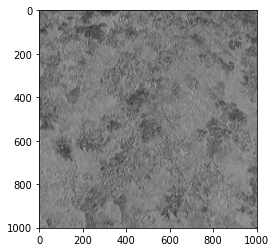

In [27]:
plt.imshow(convolution_new, cmap='gray')

In [10]:
def gradients(image):
    gradients_matrix = np.zeros(((image.shape[0]), 
                                   (image.shape[1]), 
                                    1))
    
    for i in range(1, image.shape[0]):
        for j in range(1, image.shape[1]):
            gradient_vertical = image[i, j] - image[i, j-1]
            gradient_horizontal = image[i, j] - image[i-1, j]
            gradient_point = gradients_matrix[i, j]
            gradient_point += (gradient_vertical ** 2 + gradient_horizontal ** 2) ** (1/2)
    return (gradients_matrix)

In [11]:
def gradients_direction(image):
    gradients_matrix = np.zeros(((image.shape[0]), 
                                   (image.shape[1]), 
                                    1))
    
    for i in range(1, image.shape[0]):
        for j in range(1, image.shape[1]):
            gradient_vertical = image[i, j] - image[i, j-1]
            gradient_horizontal = image[i, j] - image[i-1, j]
            if bool(gradient_horizontal > 0 and gradient_vertical > 0) == True:
                gradient_point = gradients_matrix[i, j]
                gradient_point += math.atan(gradient_vertical / gradient_horizontal)
            else:
                continue
    return (gradients_matrix)

In [12]:
gradients_direction_maydanoz = gradients_direction(convolution_maydanoz)
gradients_maydanoz = gradients(convolution_maydanoz)
gradients_direction_yüz = gradients_direction(convolution_yüz)
gradients_yüz = gradients(convolution_yüz)
gradients_new = gradients_direction(convolution_new)

In [13]:
gradients_direction_new = gradients_direction(convolution_new1)
gradients_new = gradients(convolution_new1)
gradients_directions = gradients_direction_maydanoz[:1001, :1001, :3] * gradients_direction_yüz

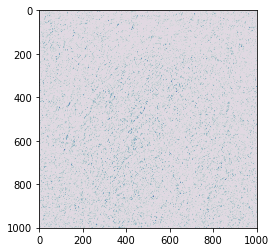

In [14]:
gradients_new = gradients_new + 2
plt.imshow(gradients_directions, cmap='twilight')

In [15]:
threshold1 = (gradients_maydanoz >= 1.38)
thresholded_image = gradients_maydanoz[threshold1]

In [16]:
def thresholding(image):
    thresholded_image = np.zeros(((image.shape[0]), 
                                   (image.shape[1]), 
                                    1))
    
    for i in range(1, image.shape[0]):
        for j in range(1, image.shape[1]):
            if bool(image[i, j, 0] >= 0.5) == True:
                thresholded_image[i, j] += (image[i, j] + 30)
            else:
                continue
    return thresholded_image

In [17]:
t_maydanoz = thresholding(gradients_maydanoz)
t_yüz = thresholding(gradients_yüz)

In [18]:
def fourier_transform(image_intensities, image_gradient):
    center_of_mass = list()
    
    for i in range(1, image_intensities.shape[0]):
        a = complex(0, 0)
        for d in range(1, image_intensities.shape[1]):
            a += image_intensities[i, d] * complex(math.cos(-d*image_gradient[i, d].sum()), 
                    math.sin(-d*image_gradient[i, d].sum()))
        center_of_mass.append(a / image_intensities.shape[0])
    
    return center_of_mass

In [28]:
centers_of_mass_maydanoz = fourier_transform(t_maydanoz, gradients_direction_maydanoz)
centers_of_mass_yüz = fourier_transform(t_yüz, gradients_direction_yüz) 
centers_of_mass_new = fourier_transform(convolution_new, gradients_new)

In [29]:
centers_of_mass1 = list()
centers_of_mass2 = list()
for i in range(len(centers_of_mass_yüz)):
    centers_of_mass1.append((centers_of_mass_maydanoz[i] + centers_of_mass_yüz[i]) / 2)
    centers_of_mass2.append(centers_of_mass_maydanoz[i] * centers_of_mass_yüz[i])

In [30]:
def inverse_fourier_transform(fourier_signal, image_intensities, image_gradient):
    inverse_fourier_image = np.zeros(((image_intensities.shape[0]), 
                                   (image_intensities.shape[1]), 
                                    1))
    
    for i in range(1, image_intensities.shape[0]):
        for d in range(1, image_intensities.shape[1]):
             inverse_fourier_image[i, d] += (1/(2*math.pi)) * complex(math.cos(d*image_gradient[i, d].sum()), 
                    math.sin(d*image_gradient[i, d].sum())).real
    
    return inverse_fourier_image

In [ ]:
#inv_fourier_maydanoz1 = inverse_fourier_transform(centers_of_mass2, t_maydanoz, gradients_direction_maydanoz)
##inv_fourier_maydanoz0 = inverse_fourier_transform(centers_of_mass1, t_maydanoz, gradients_direction_maydanoz)
##inv_fourier_maydanoz1 = inverse_fourier_transform(centers_of_mass1, t_yüz, gradients_direction_maydanoz)
#inv_fourier_maydanoz2 = inverse_fourier_transform(centers_of_mass1, t_maydanoz, gradients_direction_yüz)
#inv_fourier_maydanoz3 = inverse_fourier_transform(centers_of_mass1, t_yüz, gradients_direction_yüz)
inv_fourier_maydanoz1 = inverse_fourier_transform(centers_of_mass_new, t_maydanoz, gradients_direction_maydanoz)

In [ ]:
#print(plt.imshow(inv_fourier_maydanoz0, cmap='twilight_r'))
print(plt.imshow(inv_fourier_maydanoz1, cmap='twilight_r'))

In [ ]:
print(plt.imshow(inv_fourier_maydanoz1, cmap='twilight'))

In [ ]:
edges_inv = edge_detection_sobel(inv_fourier_maydanoz0, horizontal_sobel, vertical_sobel)
plt.imshow(edges_inv, cmap='gray')